In [1]:
import torch.utils.data as data
from PIL import Image
import os
import os.path
import torch
import numpy as np
import torchvision.transforms as transforms
import argparse
import time
import random
import numpy.ma as ma
import copy
import scipy.misc
import scipy.io as scio
from lib.proj_utils import *
from lib.transformations import translation_matrix, quaternion_matrix, quaternion_from_matrix
import quaternion as qua
from so3_data import *

/hdd/zen/dev/6dof/SO3/lib/transformations.py:1912: UserWarning: failed to import module _transformations
  warnings.warn('failed to import module %s' % name)


In [2]:
cat = "car"
data_dir = "/hdd/zen/dev/6dof/6dof_data/"
model_index = "0001"
index = 0
cld = read_pointxyz( os.path.join(data_dir, cat +"_ycb", "models"))
# value, boxes, img_color, depth_img, semantic = diplay_gen_ycb(cat, data_dir, cld, model_index, index)

In [3]:
import matplotlib.pyplot as plt
dataset_root = "/hdd/zen/dev/6dof/6dof_data/car_ycb"
transform=transforms.Compose([transforms.ToTensor()])
train_dataset = PoseDataset('train', dataset_root, transforms=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=1)

test_dataset = PoseDataset('test', dataset_root, transforms=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)


400
100


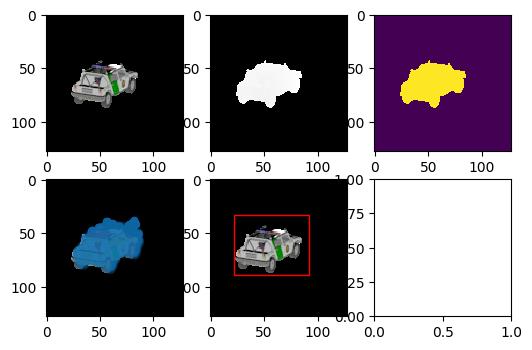

-1.0000001 0
------------------------------------------------------------------------------------------


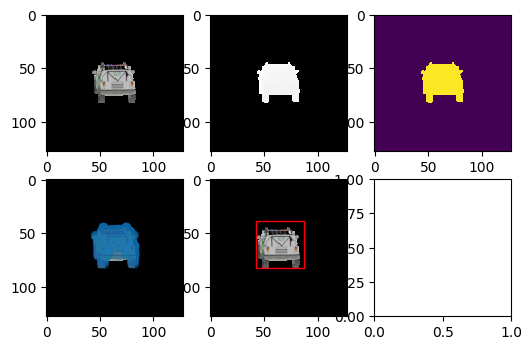

-0.9999991 1
------------------------------------------------------------------------------------------


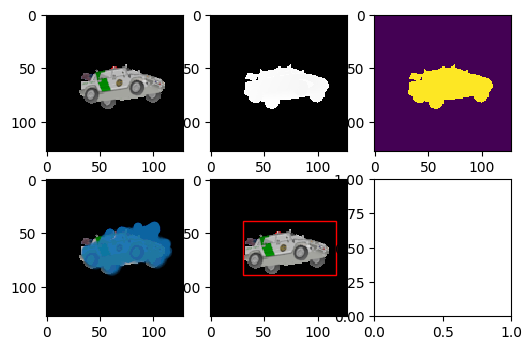

-0.99999976 2
------------------------------------------------------------------------------------------


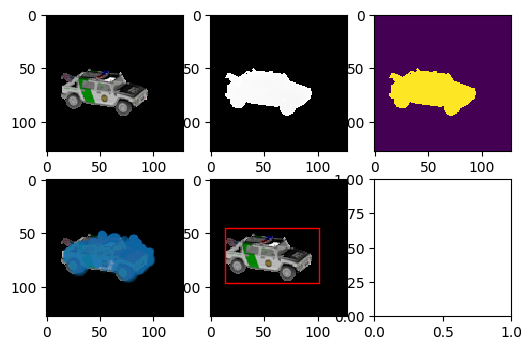

-0.9999996 3
------------------------------------------------------------------------------------------


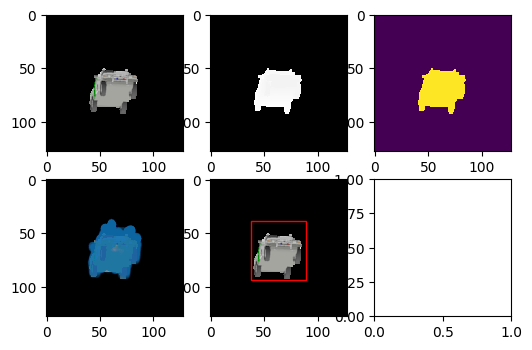

-0.99999994 4
------------------------------------------------------------------------------------------


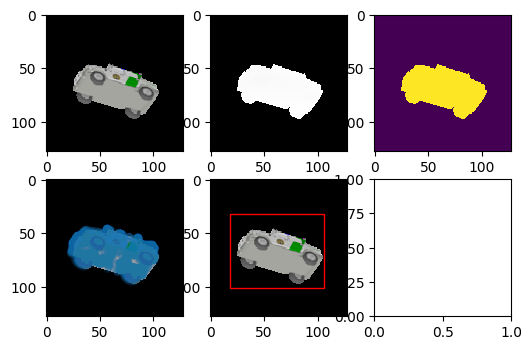

-1.0000005 5
------------------------------------------------------------------------------------------


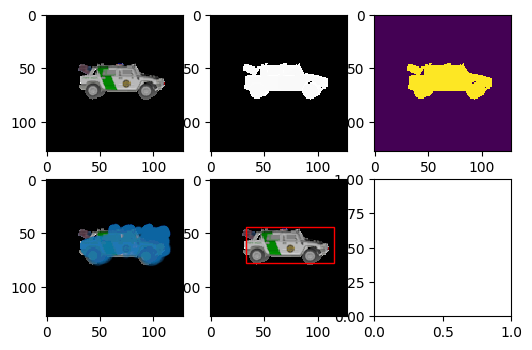

-1.0000001 6
------------------------------------------------------------------------------------------


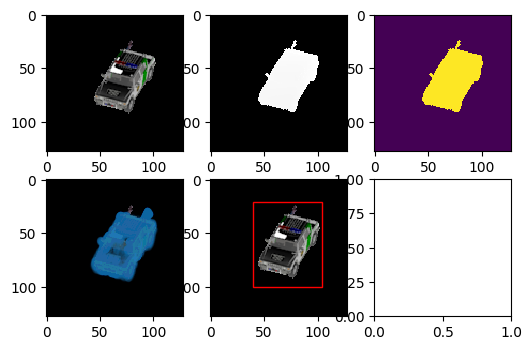

-1.0000002 7
------------------------------------------------------------------------------------------


In [4]:

## Data inspection 
for i, data in enumerate(train_loader, 0):
    img, depth, boxes, label, pose_r, pose_t, pose, cam,idx= data
#     for i in range(2, 3):
    for i in range(img.shape[0]):
        display_load_img(img[i], depth[i], boxes[i][0], label[i], cam[i], pose_t[i], pose_r[i], pose[i], train_dataset.models[idx[i]])
        print(np.linalg.det(pose[i][:3,:3]), i)
        print("------------------------------------------------------------------------------------------")
    break



In [6]:
%matplotlib widget
# %matplotlib inline

In [6]:
blender_cam = np.matrix([[1, 0, 0],
[0, -1, 0],
[0, 0, -1]])

blender_left = np.matrix([[1, 0, 0],
[0, 0, 1],
[0, 1, 0]])

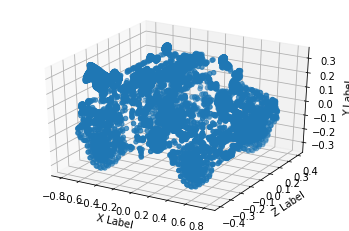

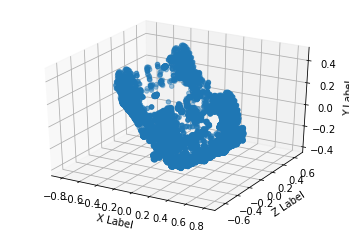

In [42]:
# Data Training loop 
# for i, data in enumerate(train_loader, 0):
#     img, depth, boxes, label, pose_r, pose_t,  cam,idx= data
#     print(pose_r.shape)
#     quat = quaternion_from_matrix(pose_r)
#     break
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.invert_zaxis()
pts = np.copy(cld['0001'])
point3d = np.matrix.transpose(np.hstack((np.matrix(pts), np.ones(len(pts)).reshape(-1, 1))))
ax.scatter(point3d[0,:], point3d[2,:], point3d[1,:])
ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')

plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pts = np.copy(cld['0001'])
point3d = np.matrix.transpose(np.hstack((np.matrix(pts), np.ones(len(pts)).reshape(-1, 1))))
iden_rot = np.identity(4)[:3,:]

iden_rot[:3, :3] = pose[i][:3,:3]
# ax.invert_zaxis()
point3d_ref = np.matmul(iden_rot, point3d)
ax.scatter(point3d_ref[0,:], point3d_ref[2,:], point3d_ref[1,:])
ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')
plt.show()

In [ ]:
# Data Training loop 
# # for i, data in enumerate(train_loader, 0):
# #     img, depth, boxes, label, pose_r, pose_t,  cam,idx= data
# #     print(pose_r.shape)
# #     quat = quaternion_from_matrix(pose_r)
# #     break
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # ax.invert_zaxis()
# pts = np.copy(cld['0001'])
# pts[:, [2, 1]]  = pts[:, [1, 2]] 
# point3d = np.matrix.transpose(np.hstack((np.matrix(pts), np.ones(len(pts)).reshape(-1, 1))))
# ax.scatter(point3d[0,:], point3d[1,:], point3d[2,:])
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# iden_rot = np.identity(4)[:3,:]
# pose_org = np.linalg.inv(blender_cam).dot(pose[i][:3,:3]).dot(np.linalg.inv(blender_left))
# iden_rot[:3, :3] = pose_org
# # ax.invert_zaxis()
# point3d_ref = np.matmul(iden_rot, point3d)
# ax.scatter(point3d_ref[0,:], point3d_ref[1,:], point3d_ref[2,:])
# ax.set_xlabel('X Label')
# ax.set_ylabel('Z Label')
# ax.set_zlabel('Y Label')
# plt.show()

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pts = np.copy(cld['0001'])
point3d = np.matrix.transpose(np.hstack((np.matrix(pts), np.ones(len(pts)).reshape(-1, 1))))
iden_rot = np.identity(4)[:3,:]

# pose_org = np.linalg.inv(blender_cam).dot(pose[i][:3,:3]).dot(np.linalg.inv(blender_left))
# iden_rot[:3, :3] = pose_org
iden_rot[:3, :3] = np.copy(pose[i][:3,:3])
iden_rot[:3,2] *= -1
# U, S, Vh = np.linalg.svd(iden_rot[:3,:3])
# S[-1] = -S[-1]
# R = U.dot(np.diag(S)).dot(Vh)
# iden_rot[:3, :3] = R
# iden_rot[:3, :3] = np.linalg.qr(pose[i][:3,:3])[0]
print(np.linalg.det(iden_rot[:3, :3]))
point3d_left = np.copy(point3d)
point3d_ref = np.matmul(iden_rot, point3d_left)
# point3d_ref = np.matmul(iden_rot, point3d)
ax.scatter(point3d_ref[0,:], point3d_ref[2,:], point3d_ref[1,:])
ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1.00000022709644


In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pts = np.copy(cld['0001'])
point3d = np.matrix.transpose(np.hstack((np.matrix(pts), np.ones(len(pts)).reshape(-1, 1))))
iden_rot = np.identity(4)[:3,:]

# pose_org = np.linalg.inv(blender_cam).dot(pose[i][:3,:3]).dot(np.linalg.inv(blender_left))
# iden_rot[:3, :3] = pose_org
iden_rot[:3, :3] = np.copy(pose[i][:3,:3])
# U, S, Vh = np.linalg.svd(iden_rot[:3,:3])
# S[-1] = -S[-1]
# R = U.dot(np.diag(S)).dot(Vh)
# iden_rot[:3, :3] = R
# iden_rot[:3, :3] = np.linalg.qr(pose[i][:3,:3])[0]
print(np.linalg.det(iden_rot[:3, :3]))

point3d_left = np.copy(point3d)
point3d_ref = np.matmul(iden_rot, point3d_left)
# point3d_ref = np.matmul(iden_rot, point3d)
ax.scatter(point3d_ref[0,:], point3d_ref[2,:], point3d_ref[1,:])
ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

-1.00000022709644


In [16]:

for k, pts in cld.items():
    # pts = cld['0001']
    plt.axis('square')
    iden_rot = np.identity(4)[:3,:]
    iden_rot[:, 3] = pose[i][:,3]
    pts2d = project_to_img(cam[i], pose[i], pts)
#     pts2d = project_to_img(cam[i], iden_rot, pts)
    plt.scatter(pts2d[0,:], pts2d[1,:])
    plt.xlim(0, 120)
    plt.ylim(0, 120)
#     plt.gca().invert_yaxis()

    plt.show()

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes